In [ ]:
# pip install tensorflow_probability==0.12.2

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import csv
from google.colab import drive
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.metrics import BigramAssocMeasures
import string
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
import re
from scipy import stats
from nltk.sentiment import SentimentIntensityAnalyzer
from tabulate import tabulate
from wordcloud import WordCloud
from gensim import corpora, models
import ast
from collections import defaultdict
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from bertopic import BERTopic
from gensim.corpora.dictionary import Dictionary
import umap
from transformers import  pipeline
from sentence_transformers import SentenceTransformer
from umap import UMAP

%matplotlib inline

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Data Collection

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import re

def scrape_transcript_to_csv(url, csv_file_path, debate_number):
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        paragraphs = soup.find_all('p')

        speaker_names, times, texts, debates = [], [], [], []
        current_speaker, current_time = None, None

        for paragraph in paragraphs:
            match = re.match(r'^(.*?)\((.*?)\):(.*)', paragraph.text)
            if match:
                current_speaker, current_time, text = match.groups()
                speaker_names.append(current_speaker.strip())
                times.append(current_time.strip())
                texts.append(text.strip())
                debates.append(debate_number)  # the debate number
            else:
                if current_speaker and texts:
                    texts[-1] += ' ' + paragraph.text.strip()

        if not speaker_names or not times or not texts:
            print("Failed to extract data correctly.")
            return

        data = list(zip(speaker_names, times, texts, debates))

        write_mode = 'w' if debate_number == 1 else 'a'
        with open(csv_file_path, write_mode, newline='', encoding='utf-8') as csvfile:
            csv_writer = csv.writer(csvfile)
            if debate_number == 1:
                csv_writer.writerow(['speaker', 'time', 'text', 'debate'])
            csv_writer.writerows(data)

        print(f"Data from {url} appended to CSV file: {csv_file_path}")
    else:
        print(f"Failed to retrieve the page. Status code: {response.status_code}")

In [ ]:
drive.mount("/drive", force_remount=True)

urls = [
    "https://www.rev.com/blog/transcripts/fox-news-republican-presidential-primary-debate-transcript",
    "https://www.rev.com/blog/transcripts/second-republican-presidential-primary-debate-transcript",
    "https://www.rev.com/blog/transcripts/rnc-third-republican-presidential-primary-debate-transcript"
]

output_filepath = '/drive/My Drive/Colab Notebooks/IST 664/Final project/debates.csv'

for i, url in enumerate(urls, start=1):
    scrape_transcript_to_csv(url, output_filepath, i)

Mounted at /drive
Data from https://www.rev.com/blog/transcripts/fox-news-republican-presidential-primary-debate-transcript appended to CSV file: /drive/My Drive/Colab Notebooks/IST 664/Final project/debates.csv
Data from https://www.rev.com/blog/transcripts/second-republican-presidential-primary-debate-transcript appended to CSV file: /drive/My Drive/Colab Notebooks/IST 664/Final project/debates.csv
Data from https://www.rev.com/blog/transcripts/rnc-third-republican-presidential-primary-debate-transcript appended to CSV file: /drive/My Drive/Colab Notebooks/IST 664/Final project/debates.csv


In [ ]:
all_debates = pd.read_csv(output_filepath)

all_debates.head()

,speaker,time,text,debate
0,Speaker 1,14:55,"Some call it the heartland. Others, fly over ...",1
1,Bret Baier,16:45,"Tonight, the race for the White House takes f...",1
2,Martha Maccallum,16:58,Eight Republican candidates have qualified an...,1
3,Bret Baier,17:15,I’m Bret Baier. This is the very same stage o...,1
4,Martha Maccallum,17:40,"Next, entrepreneur, Vivek Ramaswamy.",1


### Preprocessing

In [ ]:
# https://www.nytimes.com/interactive/2023/us/politics/debate-republican-candidates-qualify.html
# consider candidates only participants that were involved in all debate rounds. other are moderators
candidates = ['Ron DeSantis', 'Nikki Haley', 'Vivek Ramaswamy', 'Chris Christie', 'Tim Scott']
# candidates = ['Ron DeSantis', 'Nikki Haley', 'Vivek Ramaswamy', 'Chris Christie', 'Tim Scott', 'Doug Burgum', 'Asa Hutchinson', 'Mike Pence']
# replace the speaker label with moderator if not in candidate list
all_debates['speaker'] = all_debates['speaker'].apply(lambda x: x if x in candidates else 'moderator')
# focus on speakers only
df = all_debates[all_debates['speaker'] != 'moderator']
# merge the data by speaker
df = df.groupby('speaker')['text'].apply(' '.join).reset_index()
# df = all_debates.groupby('speaker')['text'].apply(' '.join).reset_index()

In [ ]:
df.head()

,speaker,text
0,Chris Christie,"Well, look, I do agree predominantly with wha..."
1,Nikki Haley,"Well, I don’t care about polls. What I care a..."
2,Ron DeSantis,Our country is in decline. This decline is no...
3,Tim Scott,"Well, thank you for the question. Over the la..."
4,Vivek Ramaswamy,"So first, let me just address a question that..."


In [ ]:
def preprocess_text(text):

    """Tokenize the text into words and perform POS tagging"""
    tagged_tokens = pos_tag(word_tokenize(text))

    """Lowercase tokens (except proper nouns), remove punctuation and numbers, and filter out short words"""
    tokens = [(w.lower() if tag not in ('NNP', 'NNPS') else w, tag) for w, tag in tagged_tokens if w.isalpha() and len(w) > 3]

    """Remove stopwords"""
    stop_words_set = set(stopwords.words('english'))
    tokens = [(w, tag) for w, tag in tokens if w not in stop_words_set]

    """Lemmatize tokens based on POS tags"""
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [(lemmatizer.lemmatize(w), tag) for w, tag in tokens]

    """POS filtering for topic modeling: select only nouns and verbs"""
    processed_tokens = [w for w, tag in lemmatized_tokens if tag.startswith('NN') or tag.startswith('VB')]

    return ' '.join(processed_tokens)

In [ ]:
# apply preprocessing to each speech
df['processed_text'] = df['text'].apply(preprocess_text)

In [ ]:
df.head()

,speaker,text,processed_text
0,Chris Christie,"Well, look, I do agree predominantly with wha...",look Governor DeSantis laid think asked agree ...
1,Nikki Haley,"Well, I don’t care about polls. What I care a...",care poll care fact telling people truth truth...
2,Ron DeSantis,Our country is in decline. This decline is no...,country decline decline choice need send Biden...
3,Tim Scott,"Well, thank you for the question. Over the la...",thank question year opportunity vote spending ...
4,Vivek Ramaswamy,"So first, let me just address a question that...",address question everybody mind home tonight h...


In [ ]:
# one possible tactic to deal with a small data frame is to duplicate it n times

def duplicate_dataset(df, n):
    return pd.concat([df] * n, ignore_index=True)

n = 20
duplicated_df = duplicate_dataset(df, n)

### Topic Modeling

General Topic Modeling

In [ ]:
# prepare embeddings
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(duplicated_df['processed_text'], show_progress_bar=False)

In [ ]:
# model BERTopic
topic_model = BERTopic()

In [ ]:
# train
topics, _ = topic_model.fit_transform(duplicated_df['processed_text'], embeddings)

In [ ]:
# reduce dimensionality of embeddings
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

In [ ]:
topics = topic_model.get_topic_info()
topics

,Topic,Count,Name,Representation,Representative_Docs
0,0,20,0_look_going_donald_people,"[look, going, donald, people, state, answer, j...",[look Governor DeSantis laid think asked agree...
1,1,20,1_need_make_china_america,"[need, make, china, america, want, know, stop,...",[care poll care fact telling people truth trut...
2,2,20,2_going_florida_country_decline,"[going, florida, country, decline, president, ...",[country decline decline choice need send Bide...
3,3,20,3_america_biden_committee_number,"[america, biden, committee, number, nation, op...",[thank question year opportunity vote spending...
4,4,20,4_country_people_think_want,"[country, people, think, want, party, generati...",[address question everybody mind home tonight ...


In [ ]:
# define the function to calculate coherence
def calculate_coherence(model, texts):
    topics = [model.get_topic(topic_idx) for topic_idx in range(len(model.get_topics()))]
    topics = [[word for word, _ in topic] for topic in topics if topic]

    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, corpus=corpus, coherence='c_v')

    return coherence_model.get_coherence()

In [ ]:
texts = [text.split() for text in duplicated_df['processed_text']]

# coherence
coherence = calculate_coherence(topic_model, texts)
print(f"Coherence Score: {coherence}")

Coherence Score: 0.4179767277793249


In [ ]:
# another way to observe

def display_topics(model):
    topic_info = model.get_topics()  # Get all topics
    for topic_num, topic in topic_info.items():
        if topic_num == -1:  # Skip the outlier topic
            continue
        print(f"Topic {topic_num}:")
        for word, prob in topic:
            print(f"    {word}: {prob:.4f}")
        print()

display_topics(topic_model)

Topic 0:
    look: 0.0535
    going: 0.0506
    donald: 0.0485
    people: 0.0463
    state: 0.0447
    answer: 0.0441
    jersey: 0.0430
    president: 0.0426
    states: 0.0422
    united: 0.0411

Topic 1:
    need: 0.0841
    make: 0.0616
    china: 0.0571
    america: 0.0416
    want: 0.0384
    know: 0.0364
    stop: 0.0345
    tell: 0.0343
    think: 0.0325
    going: 0.0320

Topic 2:
    going: 0.1213
    florida: 0.0776
    country: 0.0607
    decline: 0.0575
    president: 0.0530
    people: 0.0504
    state: 0.0425
    need: 0.0386
    done: 0.0311
    thing: 0.0304

Topic 3:
    america: 0.0595
    biden: 0.0424
    committee: 0.0424
    number: 0.0405
    nation: 0.0343
    opportunity: 0.0338
    challenge: 0.0335
    money: 0.0335
    thing: 0.0327
    household: 0.0326

Topic 4:
    country: 0.0492
    people: 0.0474
    think: 0.0444
    want: 0.0386
    party: 0.0359
    generation: 0.0287
    know: 0.0274
    home: 0.0265
    border: 0.0244
    answer: 0.0243



In [ ]:
# distance_map
distance_map = topic_model.visualize_topics()
distance_map

In [ ]:
# barchart
barchart = topic_model.visualize_barchart()
barchart

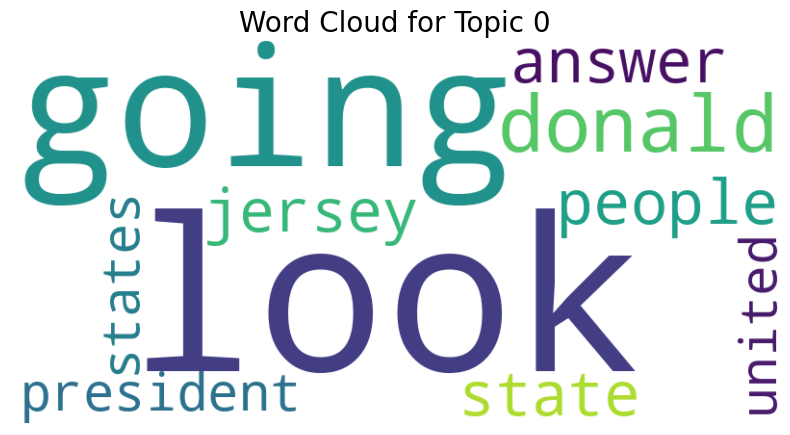

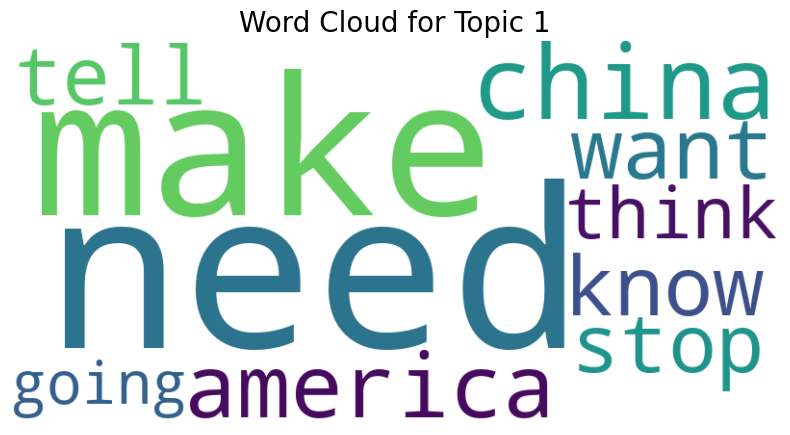

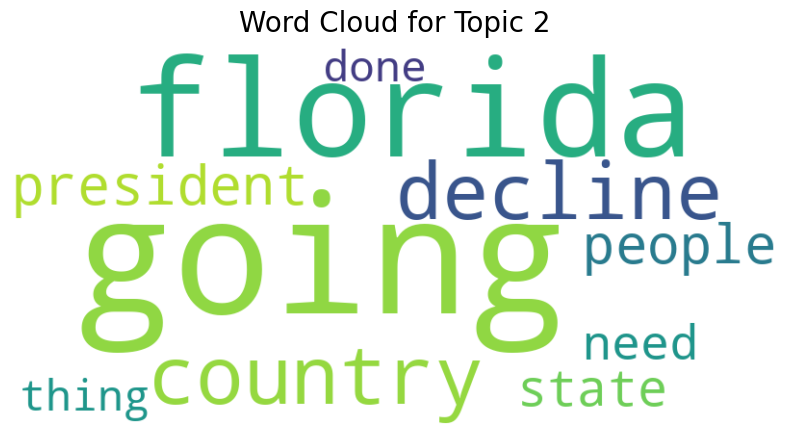

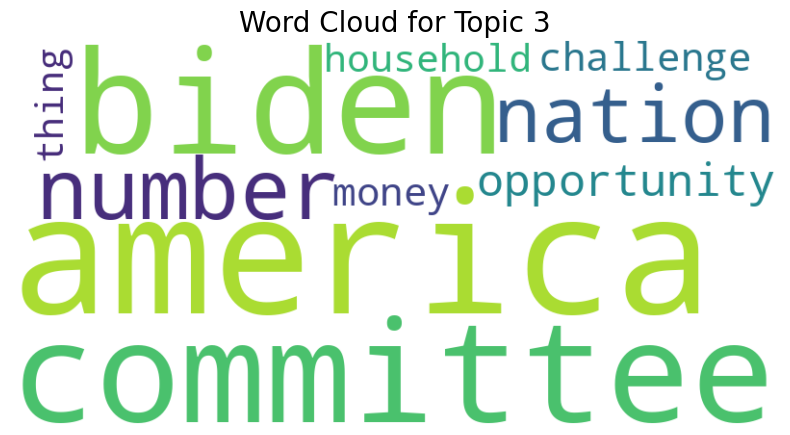

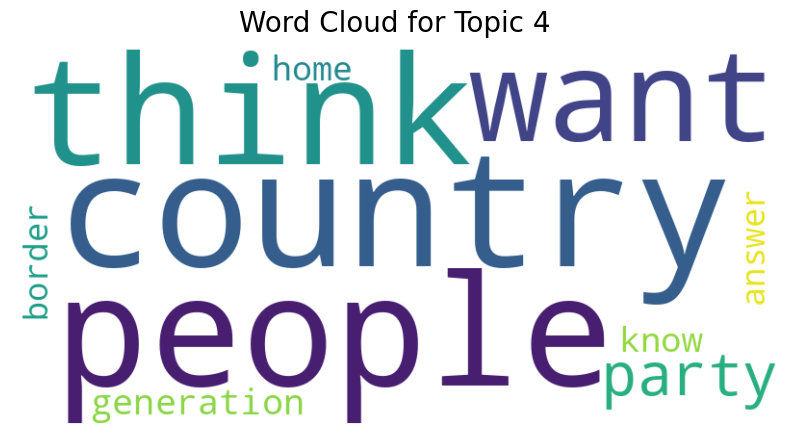

In [ ]:
# word cloud for each topic

def topic_word_clouds(model, n_topics=None):
    if n_topics is not None:
        topic_numbers = range(n_topics)
    else:
        topic_numbers = model.get_topics().keys()

    for topic_num in topic_numbers:
        if topic_num == -1:  # skip the outlier topic
            continue
        topic_words = model.get_topic(topic_num)
        if topic_words is None:
            continue

        # frequency dictionary for the word cloud
        freq_dict = {word: prob for word, prob in topic_words}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

        # image
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for Topic {topic_num}', size=20)
        plt.axis("off")
        plt.show()

topic_word_clouds(topic_model)

Topic Modeling by candidate

In [ ]:
# define UMAP model to be used within BERTopic
umap_model = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine')

# n_neighbors: higher values may lead to more global structures, while lower values may capture local structures
# n_components used for dimensionality reduction

In [ ]:
# Dictionary to store topics for each speaker
speaker_topics = {}

# Iterate over each speaker in the dataframe
for speaker in duplicated_df['speaker'].unique():
    # Initialize BERTopic for each speaker to avoid topic overlap
    speaker_topic_model = BERTopic(umap_model=umap_model)

    # Select speeches for the current speaker and convert to list
    speeches = duplicated_df[duplicated_df['speaker'] == speaker]['processed_text'].tolist()

    # Fit the model on the speeches of the speaker
    topics, probs = speaker_topic_model.fit_transform(speeches)

    # Store the topics with words and probabilities for each speaker's model
    speaker_topics[speaker] = speaker_topic_model.get_topics()

In [ ]:
speaker_topics

{'Chris Christie': {-1: [('going', 0.07878439385990495),
   ('people', 0.07123584229028805),
   ('look', 0.06601401719618526),
   ('need', 0.06334026462975163),
   ('country', 0.06334026462975163),
   ('president', 0.06062144082587708),
   ('state', 0.05785481285486073),
   ('make', 0.05785481285486073),
   ('donald', 0.04923520606071867),
   ('answer', 0.04923520606071867)]},
 'Nikki Haley': {-1: [('need', 0.11204433005999974),
   ('make', 0.08025535064425571),
   ('china', 0.07241228790031827),
   ('america', 0.05702008495107416),
   ('going', 0.0555438256460367),
   ('want', 0.0555438256460367),
   ('people', 0.04948614347315334),
   ('know', 0.04948614347315334),
   ('think', 0.04948614347315334),
   ('president', 0.04476502047744466)]},
 'Ron DeSantis': {-1: [('going', 0.14819768518121282),
   ('country', 0.08624204808868988),
   ('florida', 0.07594476995040327),
   ('people', 0.07594476995040327),
   ('president', 0.07165537273725542),
   ('need', 0.06273857956144008),
   ('state

In [ ]:
def calculate_speaker_coherences(speaker_topics, texts_by_speaker):
    speaker_coherences = {}

    for speaker, topics in speaker_topics.items():

        # extract only the words from the topics for coherence calculation
        topic_words = [[word for word, _ in topic] for topic in topics.values() if len(topic) > 1]

        # skip too small topics
        if not topic_words:
            print(f"Skipping coherence calculation for {speaker} due to insufficient topic size.")
            speaker_coherences[speaker] = float('nan')
            continue

        # speaker dictionary
        dictionary = Dictionary(texts_by_speaker[speaker])

        # corpus
        corpus = [dictionary.doc2bow(text) for text in texts_by_speaker[speaker]]

        # calculate coherence
        coherence_model = CoherenceModel(topics=topic_words, texts=texts_by_speaker[speaker],
                                         dictionary=dictionary, corpus=corpus, coherence='c_v')
        coherence = coherence_model.get_coherence()
        speaker_coherences[speaker] = coherence

    return speaker_coherences

In [ ]:
# dictionary to store the tokenized texts for each speaker
texts_by_speaker = {
    speaker: [text.split() for text in duplicated_df[duplicated_df['speaker'] == speaker]['processed_text'].tolist()]
    for speaker in duplicated_df['speaker'].unique()
}

# coherence for each speaker
speaker_coherences = calculate_speaker_coherences(speaker_topics, texts_by_speaker)

for speaker, coherence in speaker_coherences.items():
    print(f"Coherence for {speaker}: {coherence}")

Coherence for Chris Christie: 0.363229174634655
Coherence for Nikki Haley: 0.4093003042847615
Coherence for Ron DeSantis: 0.371397802262792
Coherence for Tim Scott: 0.38216557367618653
Coherence for Vivek Ramaswamy: 0.2698555408786795


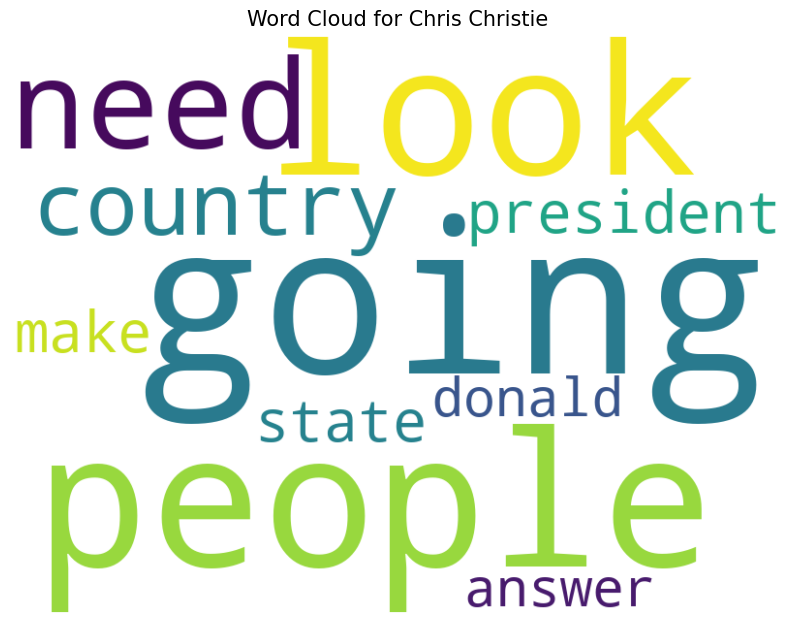

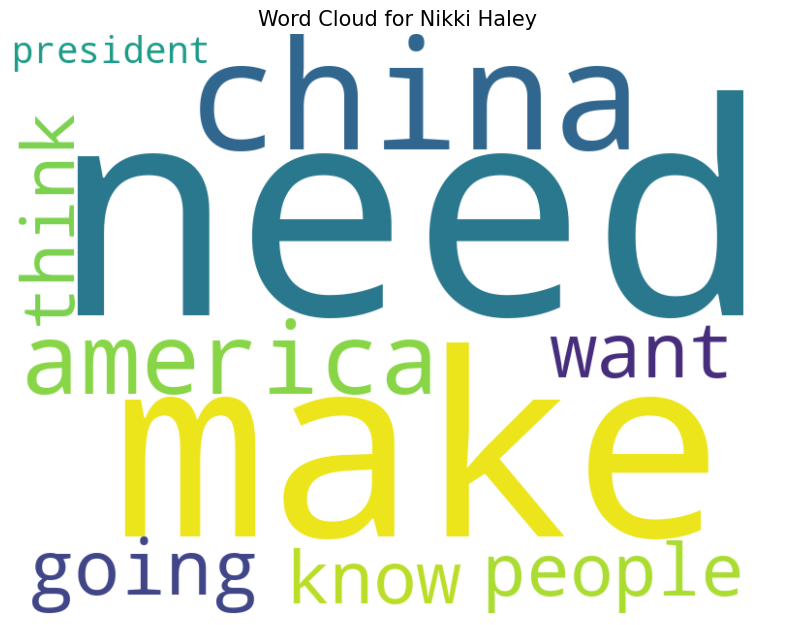

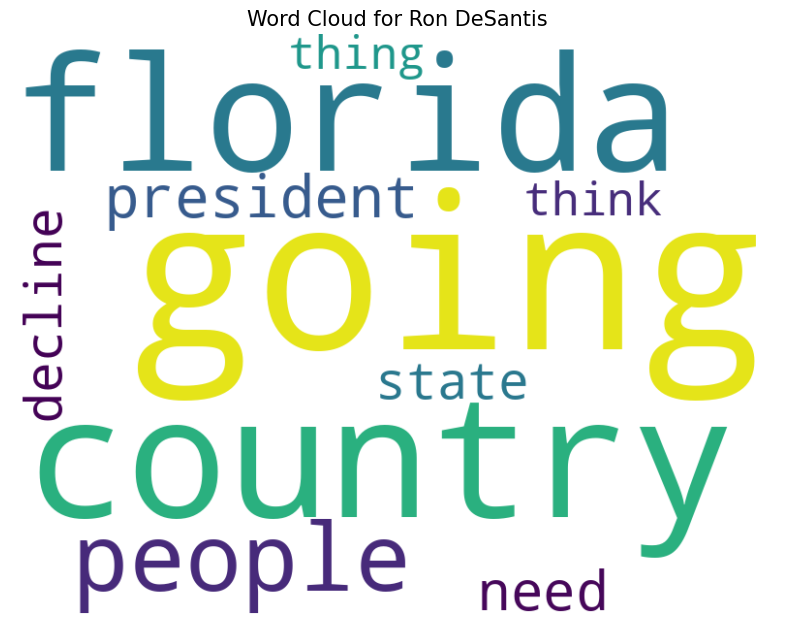

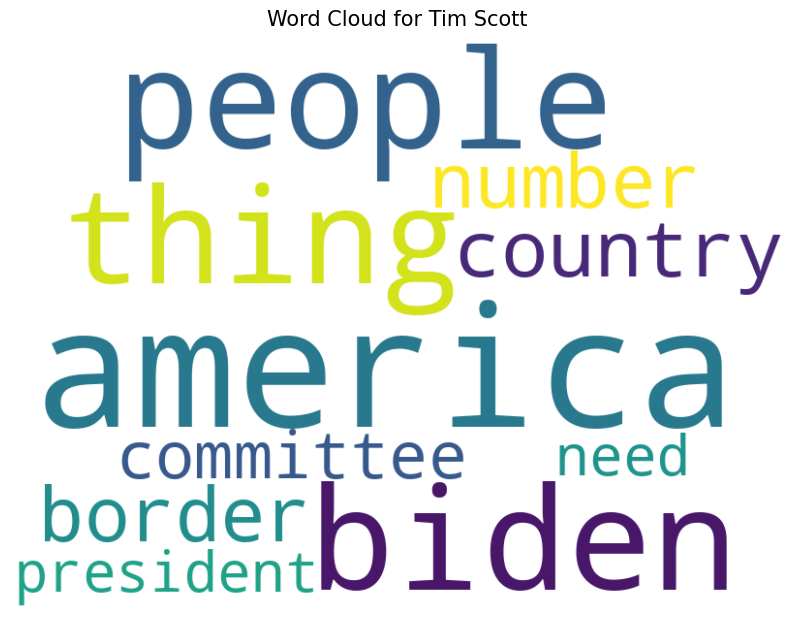

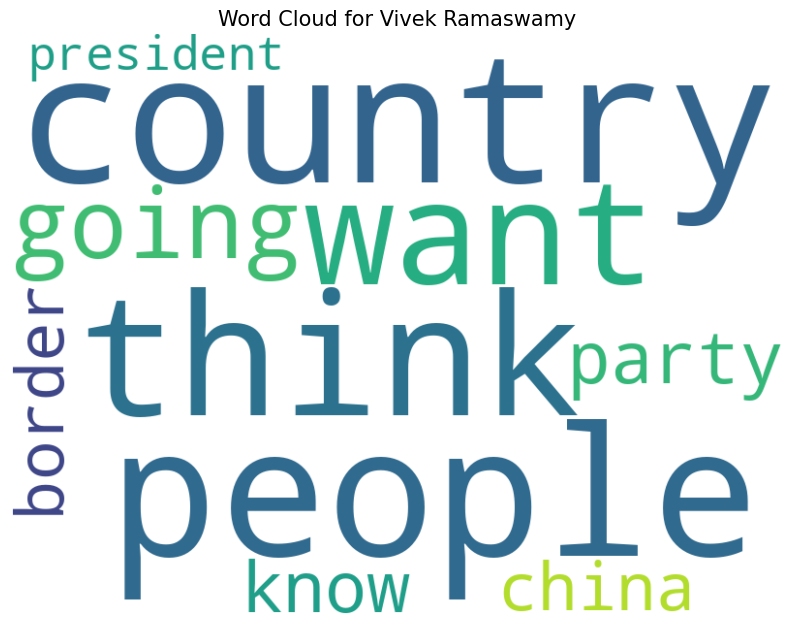

In [ ]:
def create_word_cloud(topic, speaker):
    # Convert the topic words and probabilities to a format compatible with WordCloud
    word_frequencies = {word: prob for word, prob in topic}
    wordcloud = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(word_frequencies)

    # Display the word cloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {speaker}', size=15)
    plt.axis('off')
    plt.show()

# Generate a word cloud for each speaker's topic
for speaker, topics in speaker_topics.items():
    for topic_num, topic_words in topics.items():
        create_word_cloud(topic_words, speaker)

###Sentiment analysis

In [ ]:
# pip install transformers

In [ ]:
# prepare the data
texts = df['processed_text'].astype(str)
candidates = df['speaker']

In [ ]:
# load the pipeline
sentiment_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
# split text into chunks
def split_into_chunks(text, max_len=512):
    words = text.split()
    chunks = []
    current_chunk = []
    current_len = 0
    for word in words:
        if current_len + len(word) < max_len:
            current_chunk.append(word)
            current_len += len(word) + 1
        else:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_len = len(word)
    chunks.append(' '.join(current_chunk))
    return chunks

In [ ]:
def analyze_sentiment(text):
    chunks = split_into_chunks(text)
    sentiments = [sentiment_pipeline(chunk) for chunk in chunks]
    avg_sentiment = sum([s[0]['score'] for s in sentiments]) / len(sentiments)
    return sentiments[0][0]['label'], avg_sentiment

In [ ]:
def analyze_sentiment(text):
    chunks = split_into_chunks(text)
    sentiments = [sentiment_pipeline(chunk) for chunk in chunks]
    avg_sentiment = sum([s[0]['score'] for s in sentiments]) / len(sentiments)
    return sentiments[0][0]['label'], avg_sentiment

# analyze sentiment for each text and store by candidate
sentiments_by_candidate = {}
for text, candidate in zip(texts, candidates):
    sentiment, confidence = analyze_sentiment(text)
    sentiments_by_candidate.setdefault(candidate, []).append((sentiment, confidence))

sentiments_by_candidate

{'Chris Christie': [('NEGATIVE', 0.9644730617018307)],
 'Nikki Haley': [('NEGATIVE', 0.9677891308261503)],
 'Ron DeSantis': [('NEGATIVE', 0.953872999548912)],
 'Tim Scott': [('NEGATIVE', 0.9312952319780986)],
 'Vivek Ramaswamy': [('NEGATIVE', 0.9287824332714081)]}

###Fake news detection

In [ ]:
# pip install transformers[torch]

In [ ]:
# load the labeled dataset

# https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification
# 0 = fake and 1 = real
train_dataset = pd.read_csv('/drive/My Drive/Colab Notebooks/IST 664/Final project/WELFake_Dataset.csv').drop(['Unnamed: 0'], axis=1)
train_dataset = train_dataset[['text', 'label']][:10000]

In [ ]:
# drop rows with NaN values in 'text' and 'label' columns
train_dataset = train_dataset.dropna(subset=['text', 'label'])

In [ ]:
train_dataset.head()

,text,label
0,No comment is expected from Barack Obama Membe...,1
1,Did they post their votes for Hillary already?,1
2,"Now, most of the demonstrators gathered last ...",1
3,A dozen politically active pastors came here f...,0
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
X = train_dataset['text']
y = train_dataset['label']

In [ ]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# create a pipeline with a TF-IDF vectorizer and an SVM classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('svm', SVC(probability=True))
])

In [ ]:
# train the classifier on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('svm', SVC(probability=True))])

In [ ]:
# predict labels on the test set
y_pred = pipeline.predict(X_test)

In [ ]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       951
           1       0.89      0.95      0.92      1048

    accuracy                           0.91      1999
   macro avg       0.92      0.91      0.91      1999
weighted avg       0.92      0.91      0.91      1999



In [ ]:
text = df['processed_text'].astype(str)

In [ ]:
df['predicted_labels'] = pipeline.predict(text)

In [ ]:
honesty_by_speaker = df.groupby('speaker')['predicted_labels'].agg(lambda x: x.value_counts().idxmax())
honesty_by_speaker

speaker
Chris Christie     1
Nikki Haley        1
Ron DeSantis       1
Tim Scott          1
Vivek Ramaswamy    1
Name: predicted_labels, dtype: int64